In [1]:
from scripts.utils.settings import set_seed, get_device
from scripts.utils.data import DriverDrowsinessDataset, visualize_sequence
from scripts.utils.checks import check_dataset_for_nans, check_model_weights, calculate_model_size
from scripts.models.transformers import VisionTransformer, VisionTransformerWithTemporal
from scripts.training.adversarial import AdversarialAttack
from scripts.training.loss import FocalLoss
from scripts.training.train import train, evaluate
from scripts.evaluation.report import generate_detailed_classification_report
from scripts.evaluation.viz import plot_training_history

import os
import torch
import numpy as np
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ROOT_DIR = "./processed/rgb_face"

# Define enhanced training transform with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
    transforms.RandomRotation(degrees=15),  # Randomly rotate within ±15 degrees - Remove random rotation
    transforms.ColorJitter(  # Introduce variations in brightness, contrast, saturation, and hue
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
    ),
    # transforms.RandomAffine(degrees=0, translate=(0.25, 0)),
    transforms.ToTensor(),  # Convert to tensor and rescale pixel values to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Define validation and test transforms without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

In [3]:
# Initialize training dataset
train_dataset = DriverDrowsinessDataset(
    root_dir=ROOT_DIR, 
    split="train", 
    transform=train_transform,  # Apply data augmentation for training
    seq_len=16,  # Process sequences of length 16
    padding_value=0.0,  # Use 0.0 to pad incomplete sequences
    default_img_size=224,
    stride=8,
)

# Initialize validation dataset
val_dataset = DriverDrowsinessDataset(
    root_dir=ROOT_DIR, 
    split="val", 
    transform=val_test_transform,  # No augmentation for validation
    seq_len=16, 
    padding_value=0.0,
    default_img_size=224,
    stride=2,
)

# Initialize test dataset
test_dataset = DriverDrowsinessDataset(
    root_dir=ROOT_DIR, 
    split="test", 
    transform=val_test_transform,  # No augmentation for testing
    seq_len=16, 
    padding_value=0.0,
    default_img_size=224,
    stride=2,
)

In [4]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

7531 5409 8174


In [5]:
check_dataset_for_nans(train_dataset)
check_dataset_for_nans(val_dataset)
check_dataset_for_nans(test_dataset)

Checking for NaNs in dataset: 100%|██████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.04it/s]


No NaNs or Infs found in the dataset samples checked.


Checking for NaNs in dataset: 100%|██████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.62it/s]


No NaNs or Infs found in the dataset samples checked.


Checking for NaNs in dataset: 100%|██████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.18it/s]

No NaNs or Infs found in the dataset samples checked.


True

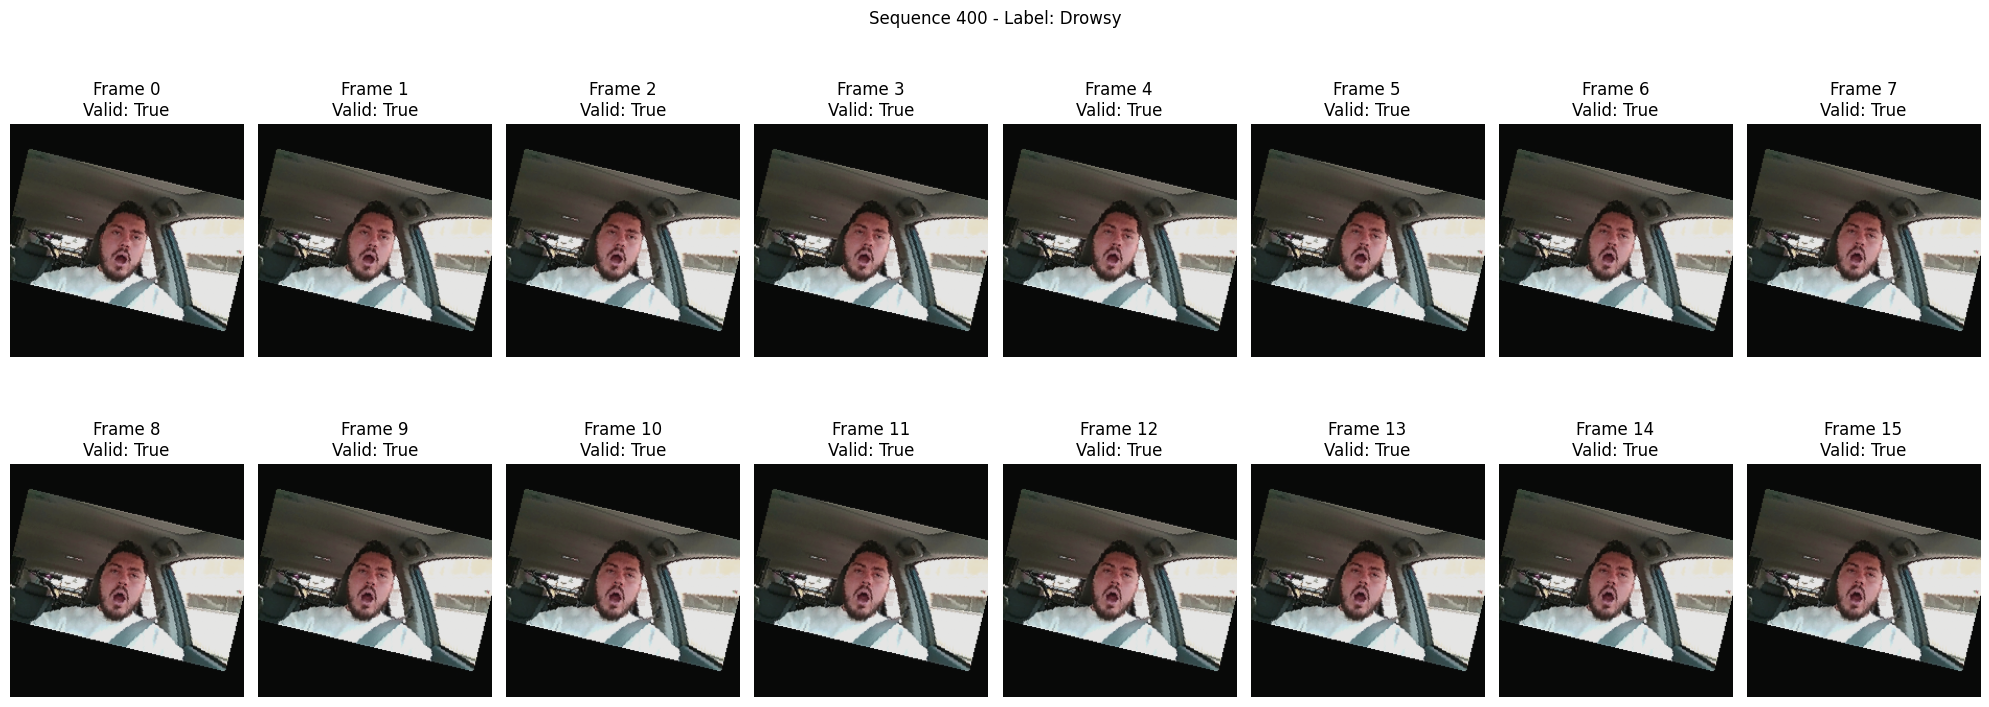

In [6]:
visualize_sequence(train_dataset, idx=400)

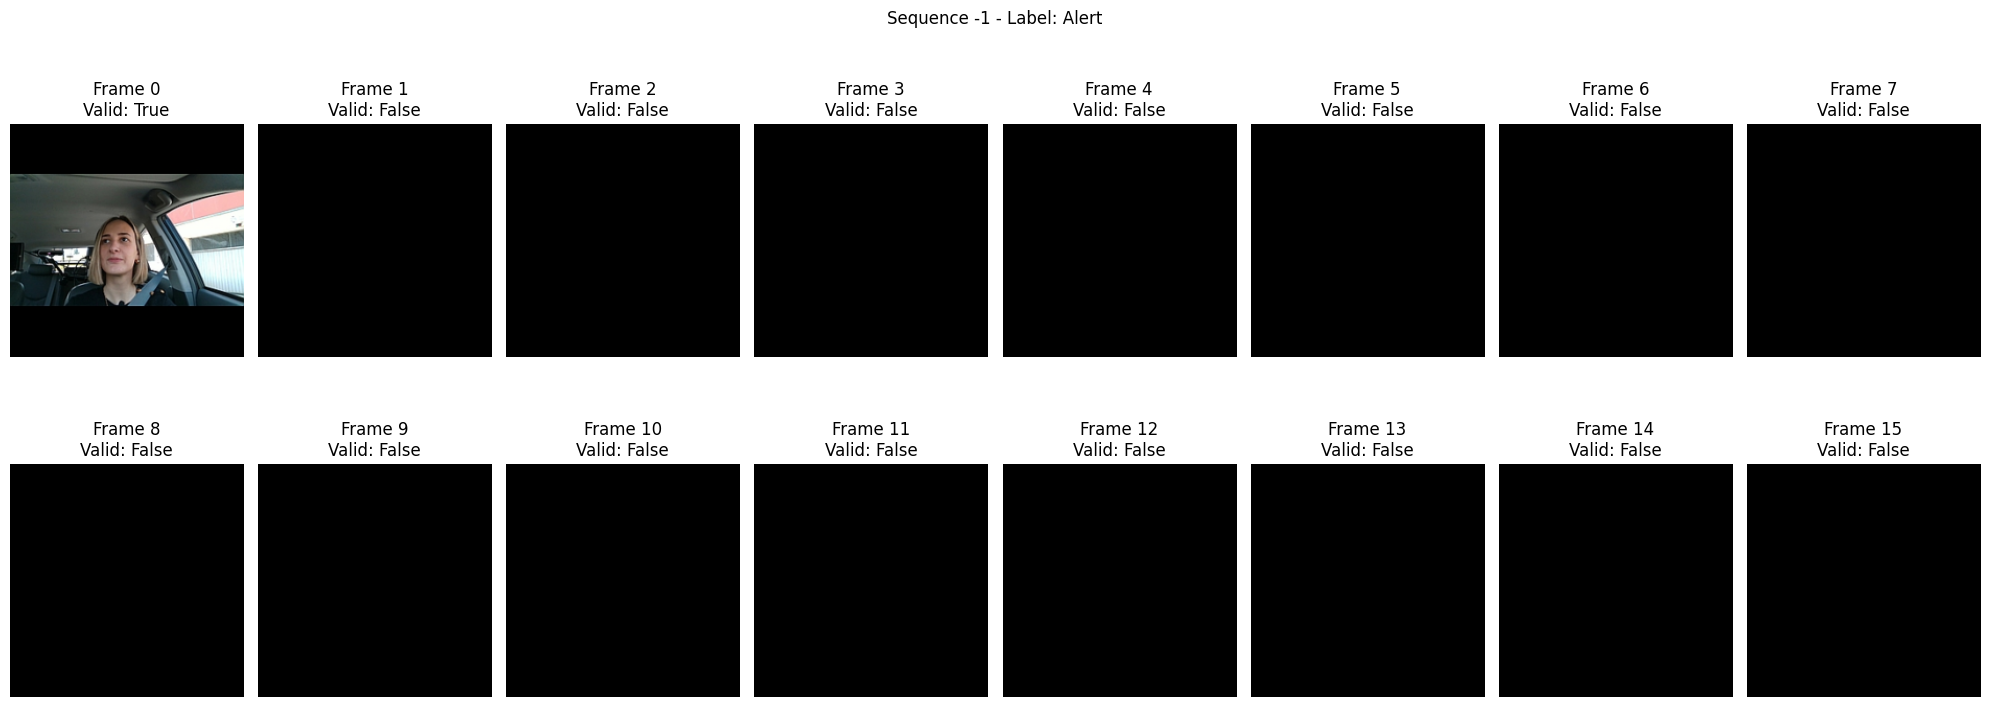

In [7]:
visualize_sequence(test_dataset, idx=-1) 

In [8]:
# Step 1: Extract labels directly from the dataset
labels = np.array([train_dataset[i][2] for i in tqdm(range(len(train_dataset)))])  # Access the labels efficiently

# Step 2: Compute class weights
unique_classes = np.unique(labels)
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=unique_classes, 
    y=labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights * (1 / class_weights[0])

# Step 3: Map class weights to sample weights
label_to_weight = {label: weight for label, weight in zip(unique_classes, class_weights)}
sample_weights = torch.tensor([label_to_weight[label] for label in labels], dtype=torch.float)

# Step 4: Create the WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # Match the total number of samples
    replacement=True  # Replacement ensures balanced sampling
)

print("Class weights:", class_weights)

100%|██████████████████████████████████████████████████████████████████████████████| 7531/7531 [07:39<00:00, 16.39it/s]

Class weights: tensor([1.0000, 6.7004])


In [9]:
# Initialize DataLoaders with optimized parameters
batch_size = 16

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler=sampler,  # Balanced sampling using WeightedRandomSampler
    drop_last=True,  # Ensure consistent batch sizes
    # num_workers=4,  # Use 4 workers for parallel data loading
    # pin_memory=True if torch.cuda.is_available() else False,  # Faster GPU transfer if using CUDA
    # prefetch_factor=2  # Prefetch batches for performance
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # No shuffling for validation
    drop_last=False,  # Include all samples
    # num_workers=4, 
    # pin_memory=True if torch.cuda.is_available() else False, 
    # prefetch_factor=2
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # No shuffling for testing
    drop_last=False,  # Include all samples
    # num_workers=4, 
    # pin_memory=True if torch.cuda.is_available() else False, 
    # prefetch_factor=2
)

In [10]:
def initialize_model(
    model_config,
    learning_rate=1e-5,
    weight_decay=1e-5,
    pretrained_weights_path=None,
    use_pretrained=False,
    weights=None,
    data_loader=None,
):
    """
    Initializes a Vision Transformer model for training, with optional temporal modeling and class weighting.

    This function sets up the Vision Transformer model, optimizer, learning rate scheduler, and loss function.
    It also handles the loading of pretrained weights if provided.

    Args:
        model_config (dict): Configuration dictionary containing model parameters such as image size, patch size,
                             embedding dimensions, number of classes, etc.
        learning_rate (float, optional): Learning rate for the optimizer. Defaults to 1e-5.
        weight_decay (float, optional): Weight decay (L2 penalty) for the optimizer. Defaults to 1e-5.
        pretrained_weights_path (str, optional): Path to the file containing pretrained model weights.
                                                If provided, the weights will be loaded into the model. Defaults to None.
        use_pretrained (bool, optional): Whether to use a pretrained Vision Transformer model. If False,
                                         a new VisionTransformerWithTemporal instance is created.
                                         Defaults to False.
        weights (torch.Tensor, optional): Tensor containing class weights for handling class imbalance.
                                          If provided, these weights will be incorporated into the loss function.
                                          Defaults to None.
        data_loader (torch.utils.data.DataLoader, optional): DataLoader for the training data.
                                                             Required if using certain schedulers like OneCycleLR.
                                                             Defaults to None.

    Returns:
        tuple: A tuple containing the following elements:
            - model (nn.Module): The initialized Vision Transformer model.
            - optimizer (torch.optim.Optimizer): The AdamW optimizer configured with the model parameters.
            - scheduler (torch.optim.lr_scheduler): The learning rate scheduler (ReduceLROnPlateau by default).
            - loss_fn (nn.Module): The loss function (CrossEntropyLoss with optional class weights).
            - device (torch.device): The device (CPU or CUDA) on which the model is placed.
    """
    # Select the device
    device = get_device()
    print(f"Using device: {device}")

    # Instantiate the Vision Transformer model
    if not use_pretrained:
        model = VisionTransformerWithTemporal(
            img_size=model_config.get("img_size", 224),
            patch_size=model_config.get("patch_size", 16),
            in_channels=model_config.get("in_channels", 3),
            num_classes=model_config["num_classes"],
            embed_dim=model_config.get("embed_dim", 768),
            depth=model_config.get("depth", 12),
            num_heads=model_config.get("num_heads", 12),
            mlp_dim=model_config.get("mlp_dim", 3072),
            dropout=model_config.get("dropout", 0.1),
            temporal_num_layers=model_config.get("temporal_num_layers", 6),
            temporal_num_heads=model_config.get("temporal_num_heads", 12),
            temporal_mlp_dim=model_config.get("temporal_mlp_dim", 3072),
            temporal_dropout=model_config.get("temporal_dropout", 0.1),
        )
    else:
        # Instantiate the Vision Transformer model
        model = VisionTransformer(
            num_classes=model_config["num_classes"],
            use_temporal_modeling=model_config.get("use_temporal_modeling", True),
            temporal_hidden_size=model_config.get("temporal_hidden_size", 128),
            dropout_p=model_config.get("dropout", 0.5),
            freeze_vit=model_config.get("freeze_vit", False),
            rnn_num_layers=model_config.get("rnn_num_layers", 1), 
            bidirectional=model_config.get("bidirectional", False),
        )

    print(model)

    # Load pretrained weights if specified
    if pretrained_weights_path:
        print(f"Loading pretrained weights from {pretrained_weights_path}")
        model.load_state_dict(torch.load(pretrained_weights_path, map_location=device))

    # Move the model to the selected device
    model.to(device)

    # Define the optimizer
    optimizer = AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    # # Use different learning rates for different parts of the model
    # param_groups = [
    #     {'params': model.patch_embed.parameters(), 'lr': learning_rate * 0.1},
    #     {'params': model.transformer_encoder.parameters()},
    #     {'params': model.temporal_encoder.parameters(), 'lr': learning_rate * 2.0},
    #     {'params': model.head.parameters(), 'lr': learning_rate * 2.0}
    # ]
    
    # optimizer = AdamW(
    #     param_groups,
    #     lr=learning_rate,
    #     weight_decay=weight_decay
    # )

    # Define the learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.1,
        patience=2,
    )
    # scheduler = OneCycleLR(
    #     optimizer,
    #     max_lr=0.01,
    #     steps_per_epoch=len(data_loader),
    #     epochs=10,
    # ) Need to change scheduler.step() as well - Very tedious

    # Define the loss function
    # if weights is not None:
    #     weights = weights.to(device)
    #     print(f"Including weights in loss computation: {weights}")
    #     loss_fn = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
    # else:
    #     loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # loss_fn = FocalLoss(alpha=None, gamma=2, reduction='mean', device=device)
    loss_fn = FocalLoss(alpha=weights, gamma=2, reduction='mean', device=device)

    return model, optimizer, scheduler, loss_fn, device

In [11]:
model_config = {
    "num_classes": 2,  # Binary classification (e.g., positive/negative)
    "use_temporal_modeling": True,
    "temporal_hidden_size": 512,
    "dropout": 0.5,
    "freeze_vit": True,
    "rnn_num_layers": 2,
    "bidirectional": False,
}

model, optimizer, scheduler, criterion, device = initialize_model(
    model_config,
    learning_rate=1e-4,  # Reduced learning rate
    weight_decay=1e-5,
    pretrained_weights_path=None,
    use_pretrained=True,
    weights=class_weights,  # Pass class weights
    data_loader=train_loader
)

Using CUDA: NVIDIA GeForce RTX 4090
Using device: cuda
Freezing Vision Transformer parameters.
VisionTransformer(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1

In [12]:
model_size = calculate_model_size(model)

print(model_size)

The model has no buffers.
{'total_params': 90526466, 'param_size': '345.331 MB', 'buffer_size': '0.000 B', 'total_size': '345.331 MB', 'total_size_with_gradients': '690.662 MB', 'size_mb': '345.331 MB'}


Training:   0%|                                                                                | 0/470 [00:00<?, ?it/s]C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\env\lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(
Validation Evaluation: 100%|█████████████████████████████████████████████████████████| 339/339 [02:44<00:00,  2.06it/s]

Validation Loss: 0.3477 | Validation Acc: 44.85% | Validation F1: 0.4066
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.97      0.40      0.56      4863
         pos       0.14      0.90      0.25       546

    accuracy                           0.45      5409
   macro avg       0.56      0.65      0.41      5409
weighted avg       0.89      0.45      0.53      5409



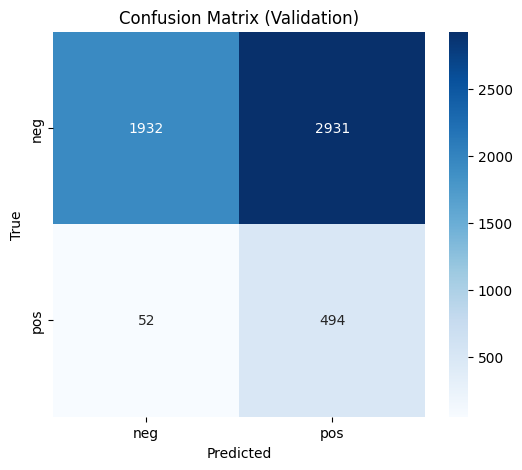

Test Evaluation: 100%|███████████████████████████████████████████████████████████████| 511/511 [04:26<00:00,  1.92it/s]

Test Loss: 0.1815 | Test Acc: 83.59% | Test F1: 0.7156
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.97      0.84      0.90      7240
         pos       0.39      0.81      0.53       934

    accuracy                           0.84      8174
   macro avg       0.68      0.83      0.72      8174
weighted avg       0.91      0.84      0.86      8174



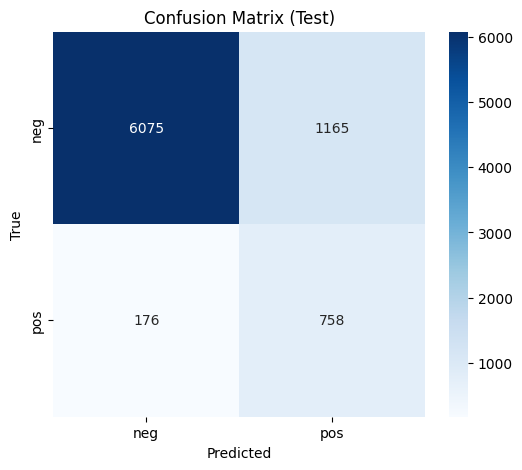

Epoch 1 Summary:
Train Loss: 0.2882 | Train Acc: 63.88% | Train F1: 0.5970
Val Loss: 0.3477 | Val Acc: 44.85% | Val F1: 0.4066
Test Loss: 0.1815 | Test Acc: 83.59% | Test F1: 0.7156
Epoch Time: 972.86s | GPU Memory Usage: 79.56 MB

Checkpoint saved at checkpoints\epoch_1.pth
Validation loss decreased. Best model saved at checkpoints\best_model.pth


Validation Evaluation: 100%|█████████████████████████████████████████████████████████| 339/339 [02:41<00:00,  2.10it/s]

Validation Loss: 0.1604 | Validation Acc: 75.06% | Validation F1: 0.6274
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.98      0.74      0.84      4863
         pos       0.27      0.87      0.41       546

    accuracy                           0.75      5409
   macro avg       0.63      0.80      0.63      5409
weighted avg       0.91      0.75      0.80      5409



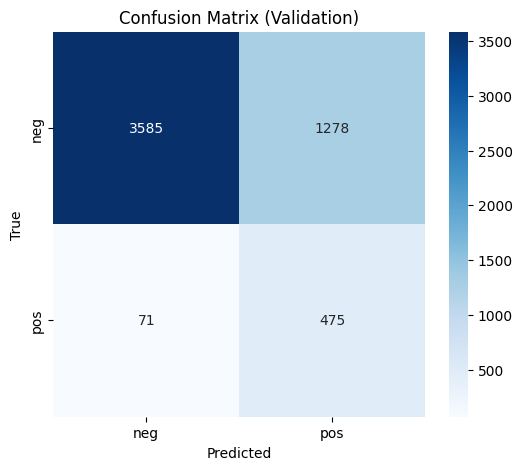

Test Evaluation: 100%|███████████████████████████████████████████████████████████████| 511/511 [04:03<00:00,  2.10it/s]

Test Loss: 0.1707 | Test Acc: 92.04% | Test F1: 0.8089
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.96      0.95      0.95      7240
         pos       0.64      0.69      0.66       934

    accuracy                           0.92      8174
   macro avg       0.80      0.82      0.81      8174
weighted avg       0.92      0.92      0.92      8174



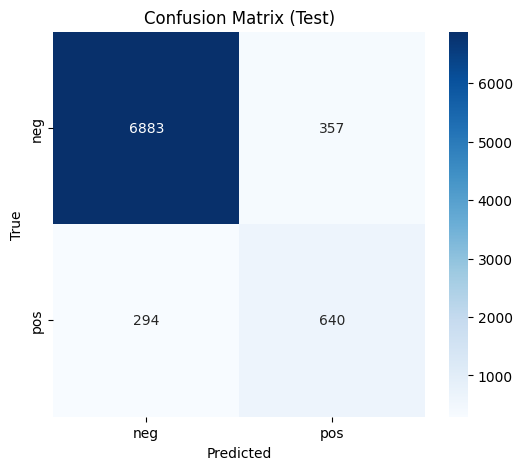

Epoch 2 Summary:
Train Loss: 0.2383 | Train Acc: 76.97% | Train F1: 0.7640
Val Loss: 0.1604 | Val Acc: 75.06% | Val F1: 0.6274
Test Loss: 0.1707 | Test Acc: 92.04% | Test F1: 0.8089
Epoch Time: 928.80s | GPU Memory Usage: -0.52 MB

Checkpoint saved at checkpoints\epoch_2.pth
Validation loss decreased. Best model saved at checkpoints\best_model.pth


Validation Evaluation: 100%|█████████████████████████████████████████████████████████| 339/339 [02:41<00:00,  2.09it/s]

Validation Loss: 0.3383 | Validation Acc: 46.29% | Validation F1: 0.4181
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.98      0.41      0.58      4863
         pos       0.15      0.92      0.26       546

    accuracy                           0.46      5409
   macro avg       0.56      0.66      0.42      5409
weighted avg       0.89      0.46      0.55      5409



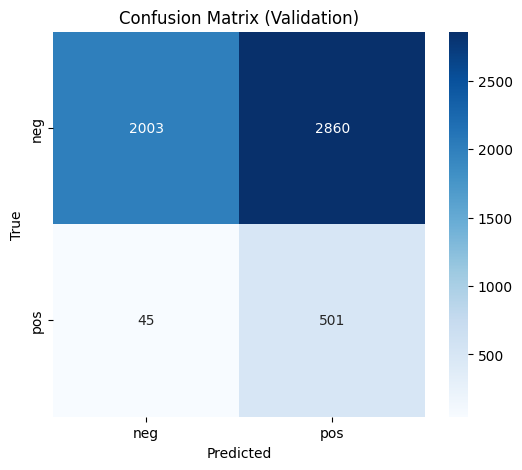

Test Evaluation: 100%|███████████████████████████████████████████████████████████████| 511/511 [04:06<00:00,  2.07it/s]

Test Loss: 0.1838 | Test Acc: 80.69% | Test F1: 0.6885
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.97      0.80      0.88      7240
         pos       0.35      0.83      0.50       934

    accuracy                           0.81      8174
   macro avg       0.66      0.82      0.69      8174
weighted avg       0.90      0.81      0.84      8174



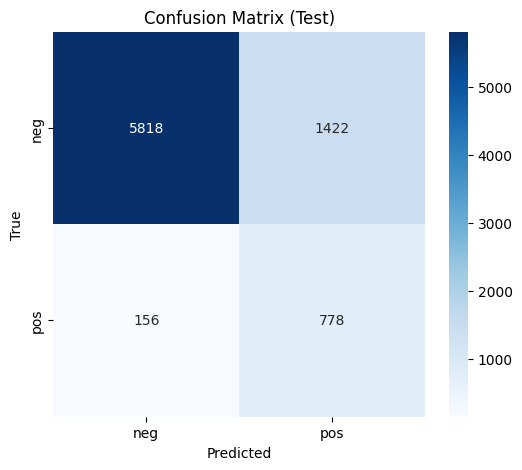

Epoch 3 Summary:
Train Loss: 0.2258 | Train Acc: 77.25% | Train F1: 0.7674
Val Loss: 0.3383 | Val Acc: 46.29% | Val F1: 0.4181
Test Loss: 0.1838 | Test Acc: 80.69% | Test F1: 0.6885
Epoch Time: 936.92s | GPU Memory Usage: 0.00 MB

Checkpoint saved at checkpoints\epoch_3.pth
No improvement in validation loss for 1 epoch(s).


Validation Evaluation: 100%|█████████████████████████████████████████████████████████| 339/339 [02:41<00:00,  2.10it/s]

Validation Loss: 0.6013 | Validation Acc: 39.34% | Validation F1: 0.3684
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.99      0.33      0.49      4863
         pos       0.14      0.96      0.24       546

    accuracy                           0.39      5409
   macro avg       0.56      0.65      0.37      5409
weighted avg       0.90      0.39      0.47      5409



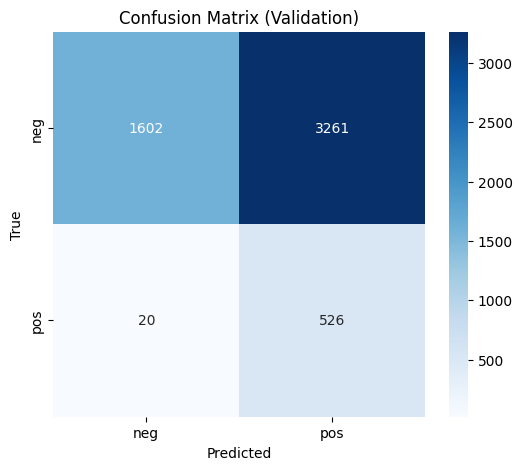

Test Evaluation: 100%|███████████████████████████████████████████████████████████████| 511/511 [04:05<00:00,  2.08it/s]

Test Loss: 0.1896 | Test Acc: 80.94% | Test F1: 0.6980
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.98      0.80      0.88      7240
         pos       0.36      0.88      0.51       934

    accuracy                           0.81      8174
   macro avg       0.67      0.84      0.70      8174
weighted avg       0.91      0.81      0.84      8174



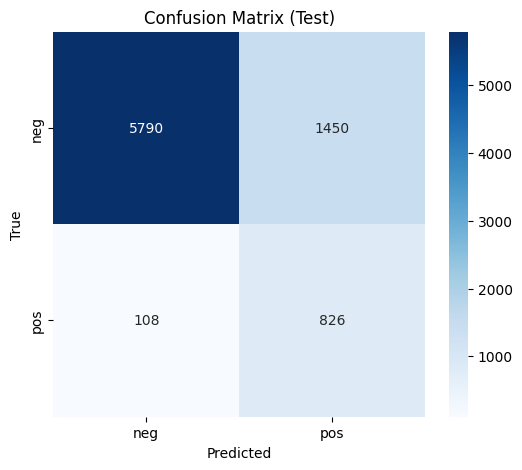

Epoch 4 Summary:
Train Loss: 0.2122 | Train Acc: 79.79% | Train F1: 0.7934
Val Loss: 0.6013 | Val Acc: 39.34% | Val F1: 0.3684
Test Loss: 0.1896 | Test Acc: 80.94% | Test F1: 0.6980
Epoch Time: 934.49s | GPU Memory Usage: 0.00 MB

Checkpoint saved at checkpoints\epoch_4.pth
No improvement in validation loss for 2 epoch(s).


Validation Evaluation: 100%|█████████████████████████████████████████████████████████| 339/339 [06:07<00:00,  1.08s/it]

Validation Loss: 0.1711 | Validation Acc: 71.25% | Validation F1: 0.6027
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.99      0.69      0.81      4863
         pos       0.25      0.92      0.39       546

    accuracy                           0.71      5409
   macro avg       0.62      0.81      0.60      5409
weighted avg       0.91      0.71      0.77      5409



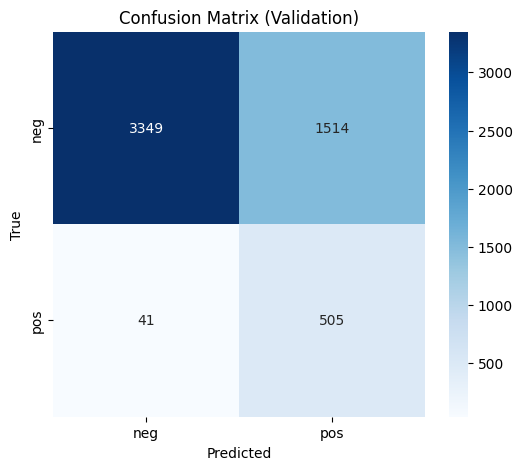

Test Evaluation: 100%|███████████████████████████████████████████████████████████████| 511/511 [18:18<00:00,  2.15s/it]

Test Loss: 0.1561 | Test Acc: 89.55% | Test F1: 0.7881
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.97      0.91      0.94      7240
         pos       0.53      0.80      0.64       934

    accuracy                           0.90      8174
   macro avg       0.75      0.86      0.79      8174
weighted avg       0.92      0.90      0.90      8174



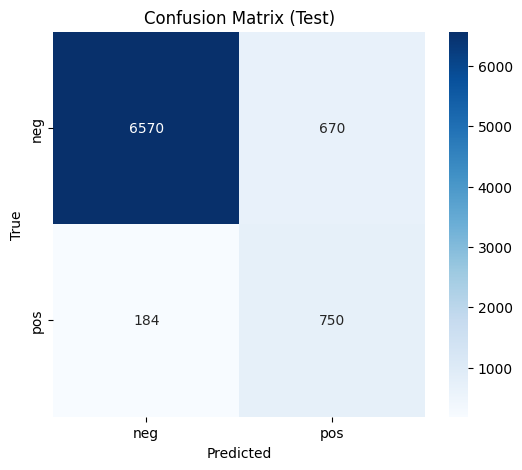

Epoch 5 Summary:
Train Loss: 0.1973 | Train Acc: 84.72% | Train F1: 0.8463
Val Loss: 0.1711 | Val Acc: 71.25% | Val F1: 0.6027
Test Loss: 0.1561 | Test Acc: 89.55% | Test F1: 0.7881
Epoch Time: 1992.71s | GPU Memory Usage: 0.00 MB

Checkpoint saved at checkpoints\epoch_5.pth
No improvement in validation loss for 3 epoch(s).


Validation Evaluation: 100%|█████████████████████████████████████████████████████████| 339/339 [02:48<00:00,  2.01it/s]

Validation Loss: 0.1524 | Validation Acc: 83.82% | Validation F1: 0.7170
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.99      0.83      0.90      4863
         pos       0.38      0.91      0.53       546

    accuracy                           0.84      5409
   macro avg       0.68      0.87      0.72      5409
weighted avg       0.93      0.84      0.86      5409



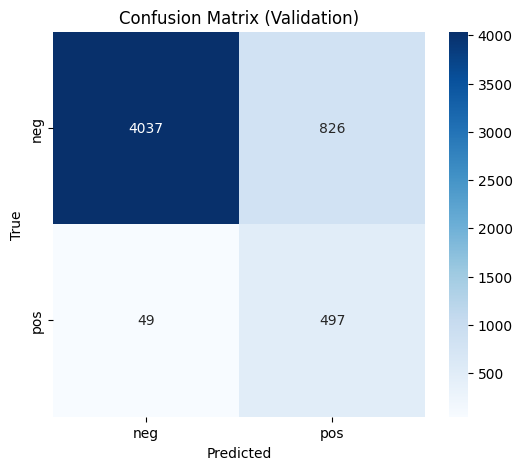

Test Evaluation: 100%|███████████████████████████████████████████████████████████████| 511/511 [04:17<00:00,  1.98it/s]

Test Loss: 0.1676 | Test Acc: 92.51% | Test F1: 0.8285
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.97      0.95      0.96      7240
         pos       0.65      0.76      0.70       934

    accuracy                           0.93      8174
   macro avg       0.81      0.85      0.83      8174
weighted avg       0.93      0.93      0.93      8174



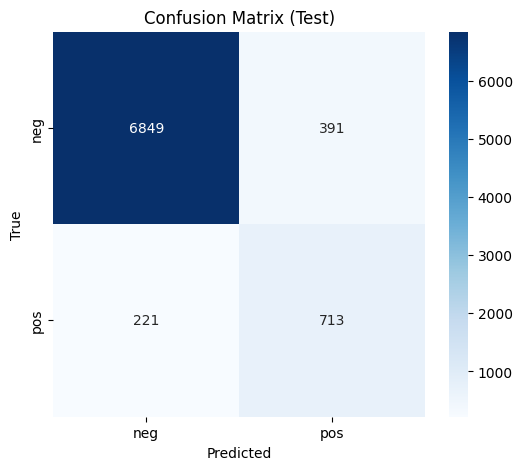

Epoch 6 Summary:
Train Loss: 0.1615 | Train Acc: 87.55% | Train F1: 0.8749
Val Loss: 0.1524 | Val Acc: 83.82% | Val F1: 0.7170
Test Loss: 0.1676 | Test Acc: 92.51% | Test F1: 0.8285
Epoch Time: 1334.89s | GPU Memory Usage: 0.00 MB

Checkpoint saved at checkpoints\epoch_6.pth
Validation loss decreased. Best model saved at checkpoints\best_model.pth


Validation Evaluation: 100%|█████████████████████████████████████████████████████████| 339/339 [02:42<00:00,  2.09it/s]

Validation Loss: 0.1504 | Validation Acc: 81.40% | Validation F1: 0.6924
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.99      0.80      0.89      4863
         pos       0.34      0.92      0.50       546

    accuracy                           0.81      5409
   macro avg       0.67      0.86      0.69      5409
weighted avg       0.92      0.81      0.85      5409



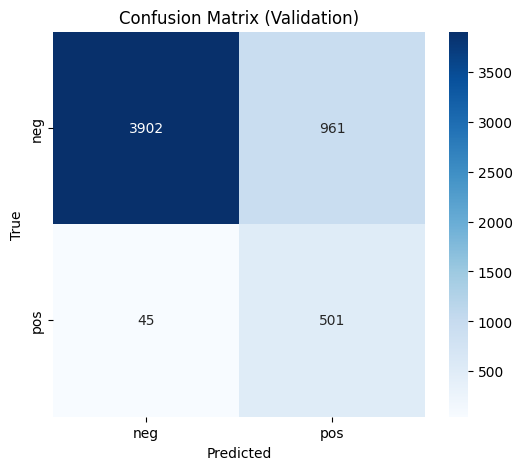

Test Evaluation: 100%|███████████████████████████████████████████████████████████████| 511/511 [04:05<00:00,  2.08it/s]

Test Loss: 0.1638 | Test Acc: 90.21% | Test F1: 0.7949
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.97      0.92      0.94      7240
         pos       0.55      0.78      0.65       934

    accuracy                           0.90      8174
   macro avg       0.76      0.85      0.79      8174
weighted avg       0.92      0.90      0.91      8174



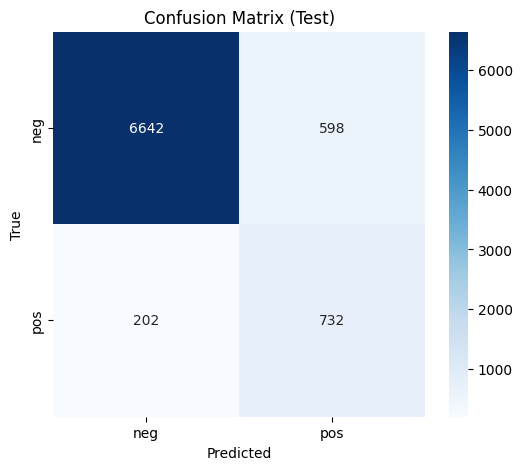

Epoch 7 Summary:
Train Loss: 0.1644 | Train Acc: 87.73% | Train F1: 0.8768
Val Loss: 0.1504 | Val Acc: 81.40% | Val F1: 0.6924
Test Loss: 0.1638 | Test Acc: 90.21% | Test F1: 0.7949
Epoch Time: 983.86s | GPU Memory Usage: 0.00 MB

Checkpoint saved at checkpoints\epoch_7.pth
Validation loss decreased. Best model saved at checkpoints\best_model.pth


Validation Evaluation: 100%|█████████████████████████████████████████████████████████| 339/339 [02:40<00:00,  2.12it/s]

Validation Loss: 0.1739 | Validation Acc: 73.17% | Validation F1: 0.6190
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.99      0.71      0.83      4863
         pos       0.26      0.93      0.41       546

    accuracy                           0.73      5409
   macro avg       0.63      0.82      0.62      5409
weighted avg       0.92      0.73      0.78      5409



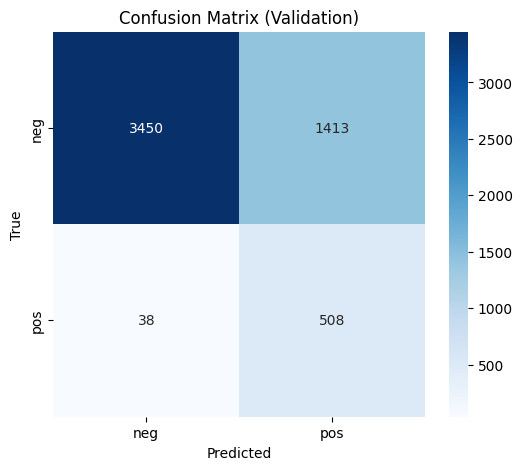

Test Evaluation: 100%|███████████████████████████████████████████████████████████████| 511/511 [04:02<00:00,  2.11it/s]

Test Loss: 0.1697 | Test Acc: 89.33% | Test F1: 0.7842
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.97      0.91      0.94      7240
         pos       0.52      0.80      0.63       934

    accuracy                           0.89      8174
   macro avg       0.75      0.85      0.78      8174
weighted avg       0.92      0.89      0.90      8174



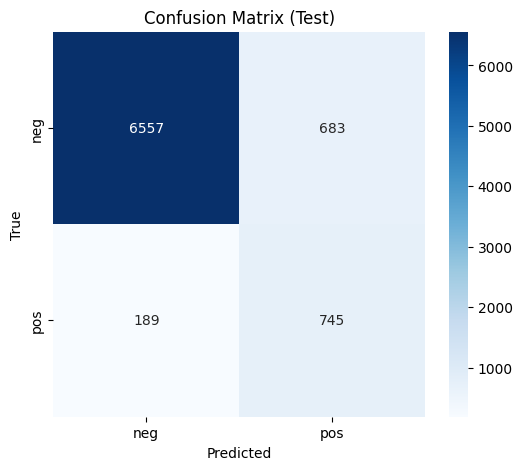

Epoch 8 Summary:
Train Loss: 0.1570 | Train Acc: 88.58% | Train F1: 0.8853
Val Loss: 0.1739 | Val Acc: 73.17% | Val F1: 0.6190
Test Loss: 0.1697 | Test Acc: 89.33% | Test F1: 0.7842
Epoch Time: 930.94s | GPU Memory Usage: 0.00 MB

Checkpoint saved at checkpoints\epoch_8.pth
No improvement in validation loss for 1 epoch(s).


Validation Evaluation: 100%|█████████████████████████████████████████████████████████| 339/339 [02:40<00:00,  2.11it/s]

Validation Loss: 0.1535 | Validation Acc: 79.39% | Validation F1: 0.6742
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.99      0.78      0.87      4863
         pos       0.32      0.93      0.48       546

    accuracy                           0.79      5409
   macro avg       0.66      0.85      0.67      5409
weighted avg       0.92      0.79      0.83      5409



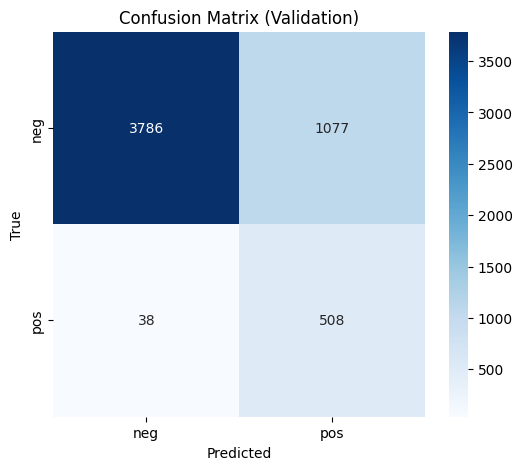

Test Evaluation: 100%|███████████████████████████████████████████████████████████████| 511/511 [04:01<00:00,  2.11it/s]

Test Loss: 0.1689 | Test Acc: 89.78% | Test F1: 0.7891
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.97      0.91      0.94      7240
         pos       0.54      0.79      0.64       934

    accuracy                           0.90      8174
   macro avg       0.75      0.85      0.79      8174
weighted avg       0.92      0.90      0.91      8174



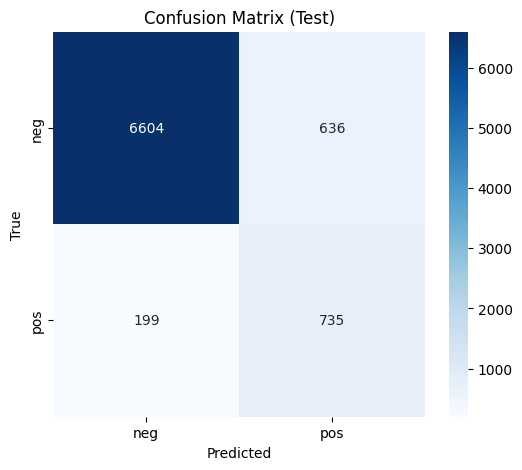

Epoch 9 Summary:
Train Loss: 0.1601 | Train Acc: 88.86% | Train F1: 0.8883
Val Loss: 0.1535 | Val Acc: 79.39% | Val F1: 0.6742
Test Loss: 0.1689 | Test Acc: 89.78% | Test F1: 0.7891
Epoch Time: 929.23s | GPU Memory Usage: 0.00 MB

Checkpoint saved at checkpoints\epoch_9.pth
No improvement in validation loss for 2 epoch(s).


Validation Evaluation: 100%|█████████████████████████████████████████████████████████| 339/339 [02:40<00:00,  2.11it/s]

Validation Loss: 0.1314 | Validation Acc: 87.65% | Validation F1: 0.7633
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.99      0.87      0.93      4863
         pos       0.45      0.92      0.60       546

    accuracy                           0.88      5409
   macro avg       0.72      0.89      0.76      5409
weighted avg       0.93      0.88      0.89      5409



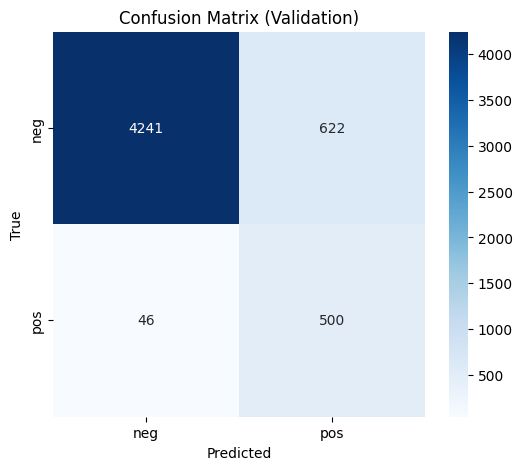

Test Evaluation: 100%|███████████████████████████████████████████████████████████████| 511/511 [04:01<00:00,  2.11it/s]

Test Loss: 0.1939 | Test Acc: 92.41% | Test F1: 0.8208
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.96      0.95      0.96      7240
         pos       0.65      0.72      0.68       934

    accuracy                           0.92      8174
   macro avg       0.81      0.84      0.82      8174
weighted avg       0.93      0.92      0.93      8174



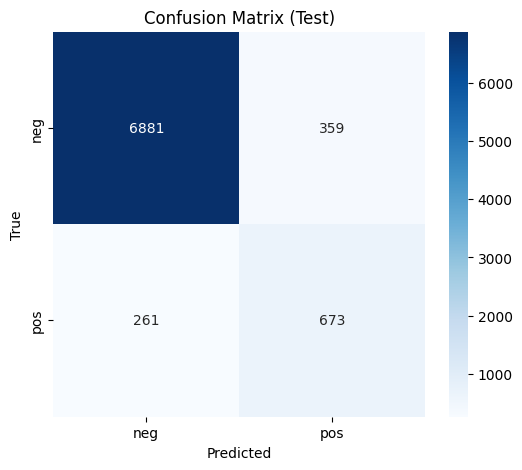

Epoch 10 Summary:
Train Loss: 0.1522 | Train Acc: 89.68% | Train F1: 0.8966
Val Loss: 0.1314 | Val Acc: 87.65% | Val F1: 0.7633
Test Loss: 0.1939 | Test Acc: 92.41% | Test F1: 0.8208
Epoch Time: 928.61s | GPU Memory Usage: 0.00 MB

Checkpoint saved at checkpoints\epoch_10.pth
Validation loss decreased. Best model saved at checkpoints\best_model.pth


In [13]:
# Number of training epochs
num_epochs = 10  # Adjust as necessary to balance performance and overfitting risks

# Train the model and record training history
history_df = train(
    model=model,  # The initialized VisionTransformerWithTemporal model
    train_loader=train_loader,  # DataLoader for training data
    val_loader=val_loader,  # DataLoader for validation data
    test_loader=test_loader,  # DataLoader for test data
    criterion=criterion,  # Loss function (e.g., CrossEntropyLoss)
    optimizer=optimizer,  # Optimizer (e.g., AdamW)
    scheduler=scheduler,  # Learning rate scheduler (e.g., ReduceLROnPlateau)
    device=device,  # Computation device (e.g., 'cuda', 'mps', or 'cpu')
    num_epochs=num_epochs,  # Total number of epochs to train
    patience=5,  # Early stopping patience to prevent overfitting
    checkpoint_dir='checkpoints',  # Directory to save model checkpoints
    save_every=1  # Save a checkpoint after every epoch
)

# Validate history_df
assert history_df is not None, "Training returned no history. Check the train function."
assert not history_df.empty, "History DataFrame is empty. Check for issues in training or logging."

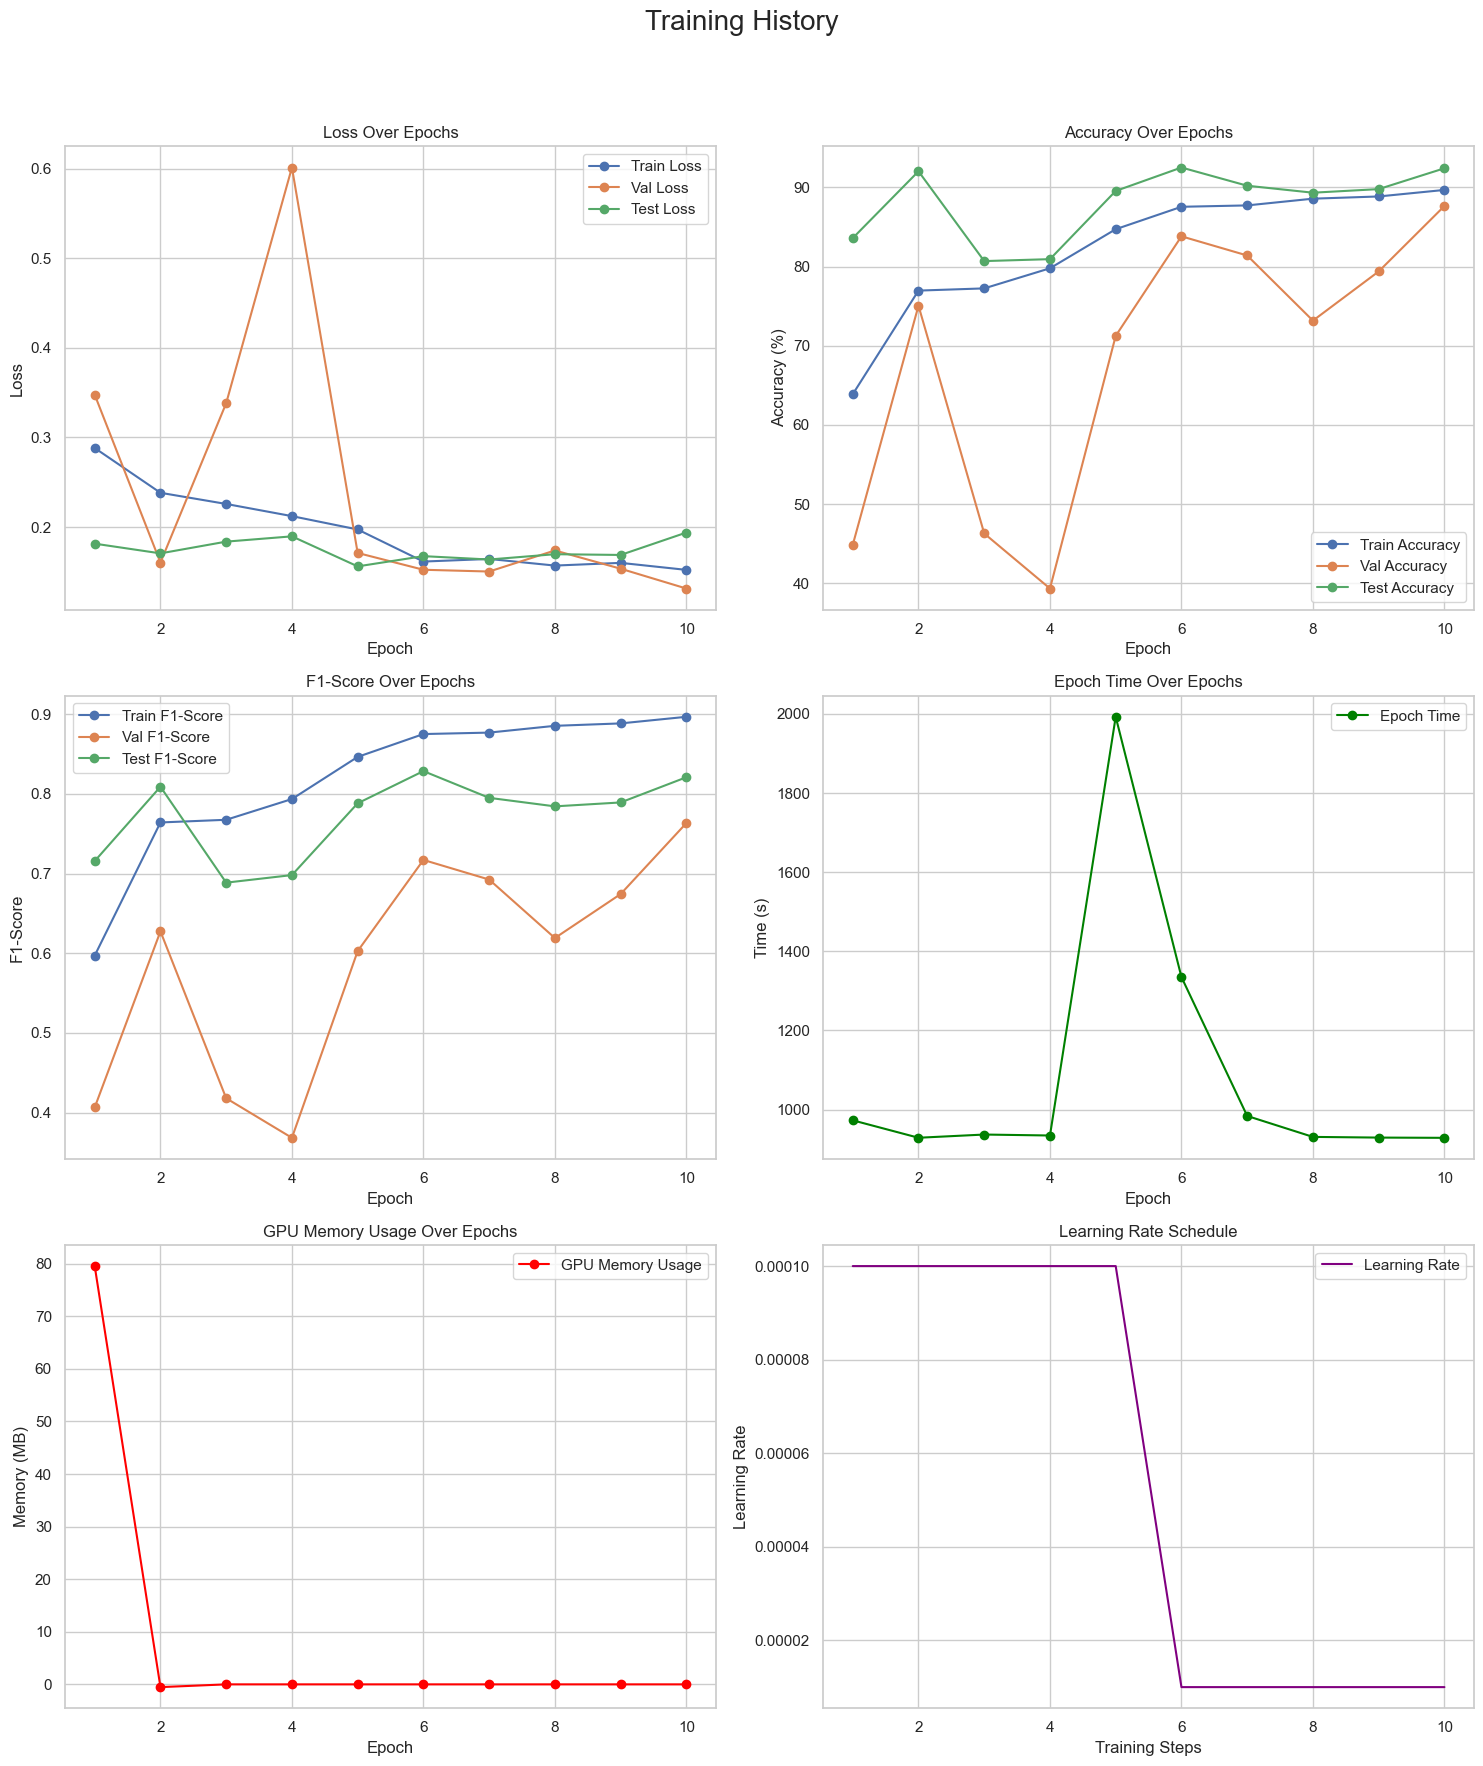

In [14]:
# Plot training history
plot_training_history(history_df)

C:\Users\User\AppData\Local\Temp\ipykernel_13784\2114616987.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_locatio

Best model loaded successfully.


Test Evaluation: 100%|███████████████████████████████████████████████████████████████| 511/511 [04:04<00:00,  2.09it/s]

Test Loss: 0.1939 | Test Acc: 92.41% | Test F1: 0.8208
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.96      0.95      0.96      7240
         pos       0.65      0.72      0.68       934

    accuracy                           0.92      8174
   macro avg       0.81      0.84      0.82      8174
weighted avg       0.93      0.92      0.93      8174



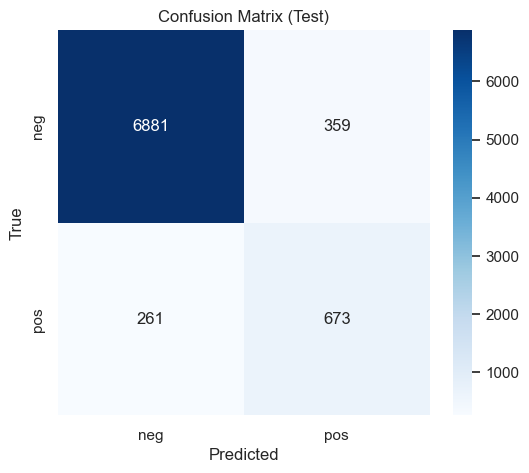

Test Loss: 0.1939
Test Accuracy: 92.41%
Test F1-Score: 0.8208


In [15]:
# Path to the best model checkpoint
best_model_path = os.path.join('checkpoints', "best_model.pth")

# Ensure the checkpoint file exists
assert os.path.exists(best_model_path), f"Checkpoint file not found: {best_model_path}"

# Load the best model weights
try:
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("Best model loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading checkpoint: {e}")

# Evaluate the model on the test dataset
test_metrics = evaluate(
    model=model, 
    data_loader=test_loader, 
    criterion=criterion, 
    device=device, 
    classes=['neg', 'pos'],  # Ensure these match the dataset's labels
    mode='Test'
)

# Verify and print test metrics
assert "loss" in test_metrics, "Test metrics do not contain 'loss'."
assert "accuracy" in test_metrics, "Test metrics do not contain 'accuracy'."
assert "f1_score" in test_metrics, "Test metrics do not contain 'f1_score'."

print(f"Test Loss: {test_metrics['loss']:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.2f}%")
print(f"Test F1-Score: {test_metrics['f1_score']:.4f}")

In [16]:
device = get_device()

Using CUDA: NVIDIA GeForce RTX 4090


Generating Detailed Classification Report: 100%|█████████████████████████████████████| 511/511 [04:03<00:00,  2.10it/s]

Classification Report:
               precision    recall  f1-score   support

         neg       0.96      0.95      0.96      7240
         pos       0.65      0.72      0.68       934

    accuracy                           0.92      8174
   macro avg       0.81      0.84      0.82      8174
weighted avg       0.93      0.92      0.93      8174



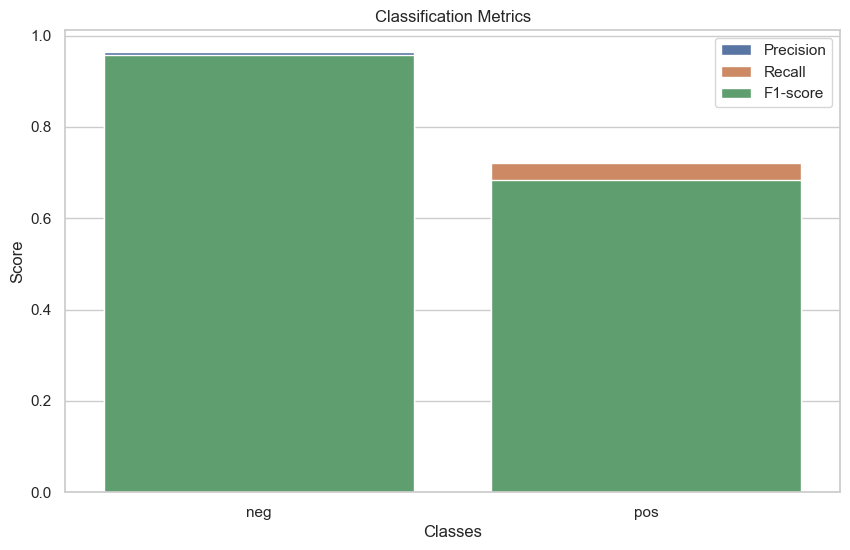

C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\scripts\evaluation\report.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df.index[:-3], y=report_df['support'][:-3], palette='viridis')


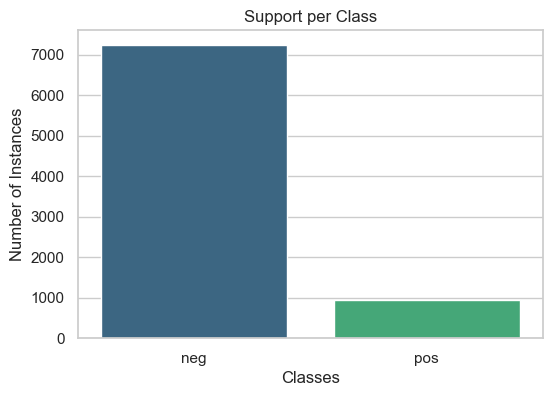

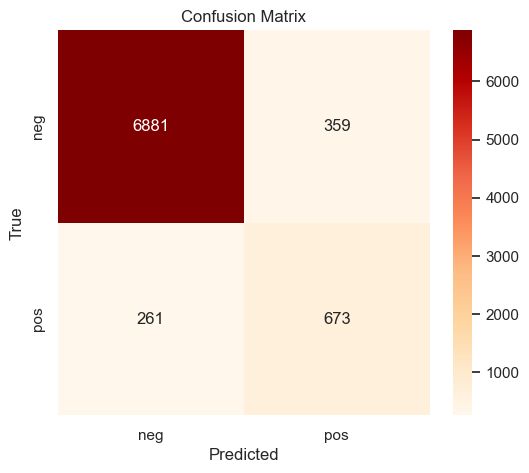

In [17]:
# Generate detailed classification report
generate_detailed_classification_report(model, test_loader, device, classes=['neg', 'pos'])

In [18]:
from scripts.inference.infer import measure_memory_inference

In [19]:
# Example Usage
# Assuming `model` is a PyTorch model and `input_data` is a tensor of appropriate shape
input_data = torch.randn(1, 16, 3, 224, 224)  # Example input for a video sequence model

# Measure memory and time
stats = measure_memory_inference(model, input_data, device)
print(f"Memory and Inference Stats: {stats}")

Memory and Inference Stats: {'cpu_memory_before_mb': 1148.73046875, 'cpu_memory_after_mb': 1242.50390625, 'cpu_memory_delta_mb': 93.7734375, 'gpu_memory_before_mb': 0.0, 'gpu_memory_after_mb': 0.0, 'gpu_memory_delta_mb': 0.0, 'inference_time_s': 0.28045225143432617}
